# Posibles mejoras

Importación de librerías:

In [1]:
import tensorflow as tf
import keras
import numpy as np
import seaborn as sns
import os
from io import BytesIO
import re
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from PIL import Image
#import PIL
from PIL import UnidentifiedImageError
from PIL import ImageFile
from keras.utils import load_img
import pandas as pd
import random
from random import sample
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.python.keras.models import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from tensorflow.keras.utils import array_to_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from tensorflow.keras.applications import VGG19

In [2]:
os.makedirs('/Datos', exist_ok = True)
os.makedirs('/Datos/Train', exist_ok=True)
os.makedirs('/Datos/Valid', exist_ok=True)

In [3]:
# Establecemos la semilla de pseudoaleatorización
random.seed('456789')

# Creamos las listas 
carpetas = []
clases = []

# Leemos las carpetas de nuestro directorio, hay 4, una por cada clase
for carpeta in os.listdir("COVID-19_Radiography_Dataset"):
    # Establecemos la ruta de cada carpeta
    carpeta_path = os.path.join("COVID-19_Radiography_Dataset",carpeta)
    # Juntamos las rutas de las carpetas en la lista *carpetas*
    carpetas.append(carpeta_path)
    
# Leemos cada una de las carpetas que corresponde con cada una de las clases
for carpeta in carpetas:
    # Establecemos el nombre de la carpeta que será el nombre de la clase
    nombre = carpeta.split(sep ='\\')[-1]
    clases.append(nombre)
    
    # Creamos dentro de los directorios Train y Valid las carpetas para cada clase
    os.makedirs('/Datos/Train/' + nombre, exist_ok = True)
    os.makedirs('/Datos/Valid/' + nombre, exist_ok = True)
    
    
    archivos = []
    train_clase = []
    valid_clase = []
    # Leemos los archivos (imágenes) de cada carpeta 
    for archivo in os.listdir(carpeta):
        archivos.append(archivo)
    # Seleccionamos 1000 + 300 imágenes de cada carpeta
    seleccion = sample(archivos, 1300)
    
    # Dividimos las imágenes seleccionadas en train y valid
    train_clase = seleccion[:1000]
    valid_clase = seleccion[1000:]
    
    # Copiamos las imágenes de train y valid en sus respectivas carpetas
    for imagen in train_clase:
        img_path = os.path.join(carpeta, imagen)
        shutil.copy(img_path, os.path.join('/Datos/Train',nombre, imagen))
    for imagen in valid_clase:
        img_path = os.path.join(carpeta, imagen)
        shutil.copy(img_path, os.path.join('/Datos/Valid',nombre, imagen))

# DATA AUGMENTATION

Usaremos la función ImageDataGenerator, para data augmentation:

In [4]:
data_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.05,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip = False,
        fill_mode='nearest')

Veamos un ejemplo:

In [5]:
# Elegimos una imagen para ser "aumentada"

from random import randrange

# Elegimos de forma aleatoria la clase
clase_elegida = random.choice(clases)
x = clases.index(clase_elegida)
rango = list(os.listdir(carpetas[x]))
num = random.choice(rango)


# Carga de la imagen
img_prueba = load_img(os.path.join(carpetas[x],num))

# Transformación de la imagen PIL a array
img_prueba_array = img_to_array(img_prueba)

# Redimensionado
img_shape = img_prueba_array.reshape((1,) + img_prueba_array.shape)

os.makedirs('/Datos/Ejemplo', exist_ok=True)
i = 0
for batch in data_gen.flow(img_shape, 
                           batch_size=1,
                           save_to_dir='/Datos/Ejemplo'):
    i += 1
    if i > 20:
        break

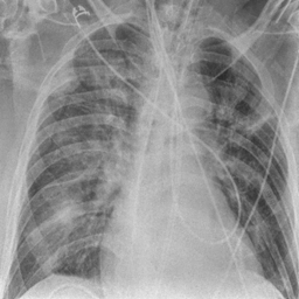

In [6]:
img_prueba

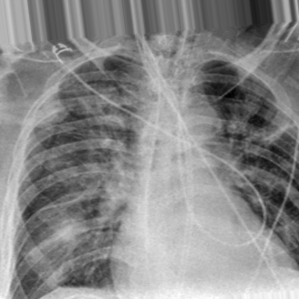

In [7]:
img_aum = []
for imagen in os.listdir('/Datos/Ejemplo'):  
    imagen_path = os.path.join("C:\Datos\Ejemplo",imagen)
    img_aum.append(imagen_path)
load_img(img_aum[1])

Pasamos ahora a hacer el data augmentation para los conjunto train, test y valid:

In [8]:
batch_size = 20

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)


train_generator = train_datagen.flow_from_directory(
        '/Data/Train',
        target_size=(299, 299),  
        batch_size=batch_size,
        class_mode='binary')  

test_generator = test_datagen.flow_from_directory(
        '/Data/Valid',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        '/Data/Valid',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='binary')

Found 4000 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


Se crea la red neuronal convolucional:

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(299, 299, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(4))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 activation (Activation)     (None, 297, 297, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 146, 146, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                    

Entrenamiento del modelo:

In [10]:
batch_size = 50
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 4000 // batch_size,
    epochs = 50,
    validation_data=validation_generator,
    validation_steps= 1200 // batch_size)
model.save_weights('first_try.h5')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_31012\279259270.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
80/80 [==============================] - 50s 614ms/step - loss: 1.4696 - accuracy: 0.4031 - val_loss: 0.9632 - val_accuracy: 0.5646
Epoch 2/50
80/80 [==============================] - 50s 619ms/step - loss: 1.0793 - accuracy: 0.5462 - val_loss: 0.9446 - val_accuracy: 0.6271
Epoch 3/50
80/80 [==============================] - 52s 649ms/step - loss: 0.9630 - accuracy: 0.5956 - val_loss: 0.7710 - val_accuracy: 0.6479
Epoch 4/50
80/80 [==============================] - 53s 664ms/step - loss: 0.9197 - accuracy: 0.6275 - val_loss: 0.8901 - val_accuracy: 0.6187
Epoch 5/50
80/80 [==============================] - 53s 656ms/step - loss: 0.8757 - accuracy: 0.6338 - val_loss: 0.7782 - val_accuracy: 0.6708
Epoch 6/50
80/80 [==============================] - 52s 651ms/step - loss: 0.8316 - accuracy: 0.6681 - val_loss: 0.7185 - val_accuracy: 0.7042
Epoch 7/50
80/80 [==============================] - 55s 681ms/step - loss: 0.8135 - accuracy: 0.6644 - val_loss: 0.6707 - val_accuracy: 0.7375

Evaluación del modelo:

In [11]:
model.evaluate(test_generator)

60/60 [==============================] - 9s 143ms/step - loss: 0.4675 - accuracy: 0.8317


[0.4675411880016327, 0.8316666483879089]

In [12]:
model.save('modelo_au.h5')

Resultados:

In [13]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x288 with 0 Axes>

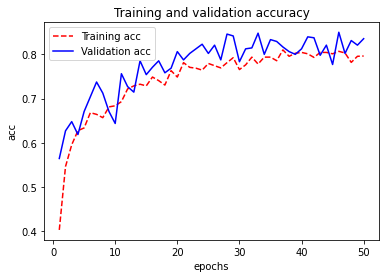

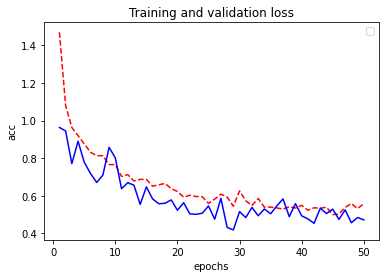

<Figure size 432x288 with 0 Axes>

In [14]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--' )
plt.plot ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

# Transfer learning: VGG19 con data augmentation

Utilizaremos un modelo preentrenado para intentar mejorar el modelo que ya teniamos usando un clasificadorpropio densamente conectado con cuatro clases:

In [15]:
model_VGG19 = VGG19(input_shape = (299,299,3),
                        include_top = False,
                        weights = 'imagenet')

model_VGG19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

Se crearán listas de imágenes de entrenamiento y validación con sus etiquetas:

In [16]:
train_images = []
train_labels = []
valid_images = []
valid_labels = []

# Leemos los archivos de Train
for root, dirs, files in os.walk('/Datos/Train'):
    # Leemos cada imagen
    for filename in files:
        # Obtenemos su ruta
        img_path = os.path.join(root, filename)
        # Cargamos la imagen
        img = load_img(img_path)
        # Convertimos la imagen en array
        img = img_to_array(img)
        # Redimentsionamos la imagen
        img = np.expand_dims(img, axis = 0)
        # Incluimos la imagen en su lista 
        train_images.append(img)
        # Obtenemos la clase de cada imagen según su nombre
        x = filename.split(sep ='-')
        x = x[0]
        # Añadimos la clase a la lista de labels
        train_labels.append(x)
    
    
# Realizamos el mismo procedimiento con las imagenes de Valid
for root, dirs, files in os.walk('/Datos/Valid'):
    for filename in files:
        img_path = os.path.join(root, filename)
        img = load_img(img_path)
        img = img_to_array(img)
        img = np.expand_dims(img, axis = 0)
        valid_images.append(img)
        x = filename.split(sep ='-')
        x = x[0]
        valid_labels.append(x)

Al igual que en el modelo original, codificaremos y extraeremos caracteristicas:

In [17]:
dic = {'COVID':0, 'Lung_Opacity':1, 'Normal':2, 'Viral Pneumonia': 3}
train_labels = [dic.get(n, n) for n in train_labels]
valid_labels = [dic.get(n, n) for n in valid_labels]

Congelaremos la base convolucional del modelo:

In [19]:
print('Estos son los pesos de entrenamiento antes de congelar la base de convolución: ', len(model_VGG19.trainable_weights))

model_VGG19.trainable = False

print('Estos son los pesos de entrenamiento despues de congelar la base de convolución: ', len(model_VGG19.trainable_weights))

Estos son los pesos de entrenamiento antes de congelar la base de convolución:  32
Estos son los pesos de entrenamiento despues de congelar la base de convolución:  0


Construcción del modelo:

In [20]:
x = keras.layers.Flatten()(model_VGG19.output)

x = keras.layers.Dense(512, activation='relu')(x)

x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Dense(4, activation='softmax')(x)

model2 = tf.keras.models.Model(model_VGG19.input, x)

model2.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
               loss = 'sparse_categorical_crossentropy',
               metrics = ['accuracy'])

Entrenamiento del modelo:

In [21]:
vgghist = model2.fit(train_generator, 
                     validation_data = validation_generator, 
                     steps_per_epoch = 100, 
                     epochs = 10)

Epoch 1/10
100/100 [==============================] - 608s 6s/step - loss: 1.4244 - accuracy: 0.4830 - val_loss: 0.7848 - val_accuracy: 0.6992
Epoch 2/10
100/100 [==============================] - 633s 6s/step - loss: 0.8580 - accuracy: 0.6340 - val_loss: 0.7764 - val_accuracy: 0.7017
Epoch 3/10
100/100 [==============================] - 633s 6s/step - loss: 0.7521 - accuracy: 0.6950 - val_loss: 0.5847 - val_accuracy: 0.7917
Epoch 4/10
100/100 [==============================] - 648s 6s/step - loss: 0.6967 - accuracy: 0.7035 - val_loss: 0.9510 - val_accuracy: 0.5958
Epoch 5/10
100/100 [==============================] - 633s 6s/step - loss: 0.6500 - accuracy: 0.7400 - val_loss: 0.5843 - val_accuracy: 0.7533
Epoch 6/10
100/100 [==============================] - 632s 6s/step - loss: 0.6253 - accuracy: 0.7495 - val_loss: 0.5020 - val_accuracy: 0.8158
Epoch 7/10
100/100 [==============================] - 637s 6s/step - loss: 0.5996 - accuracy: 0.7685 - val_loss: 0.4960 - val_accuracy: 0.8125

In [22]:
model2.evaluate(test_generator)

60/60 [==============================] - 229s 4s/step - loss: 0.4530 - accuracy: 0.8458


[0.4529697597026825, 0.8458333611488342]

In [23]:
model2_json = model2.to_json()
model2.save_weights("model2.h5py")

In [24]:
model2.save('modelo_vgg19au.h5')

Resultados:

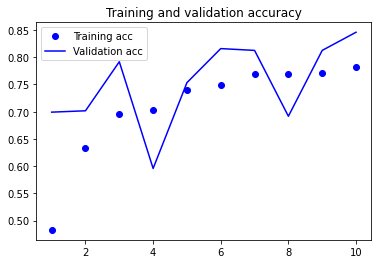

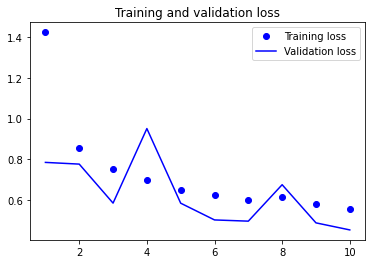

In [25]:
acc = vgghist.history['accuracy']
val_acc = vgghist.history['val_accuracy']
loss = vgghist.history['loss']
val_loss = vgghist.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Fine Tuning

Se descongelará la parte convolucional del modelo VGG19 y se congelarán todas las capas convolucionales desde la 4ª hasta la ultima. Por ultimo se compilará el modelo y se volverá a entrenar utilizando también aumento de datos.

In [26]:
model_VGG19 = VGG19(input_shape = (299,299,3),
                        include_top = False,
                        weights = 'imagenet')

model_VGG19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [27]:
model_VGG19.trainable = True

In [28]:
for layer in model_VGG19.layers[:-4]:
    layer.trainable = False

Compilación y entrenamiento:

In [29]:
model2.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics = ['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath='fine_tuning.keras',
    save_best_only=True,
    monitor='val_loss')]

history3 = model2.fit(
    train_generator,
    epochs = 10,
    steps_per_epoch = 100,
    validation_data = validation_generator,
    callbacks = callbacks)

Epoch 1/10
100/100 [==============================] - 620s 6s/step - loss: 0.4823 - accuracy: 0.8220 - val_loss: 0.4396 - val_accuracy: 0.8358
Epoch 2/10
100/100 [==============================] - 623s 6s/step - loss: 0.4712 - accuracy: 0.8170 - val_loss: 0.4328 - val_accuracy: 0.8458
Epoch 3/10
100/100 [==============================] - 642s 6s/step - loss: 0.4730 - accuracy: 0.8235 - val_loss: 0.4319 - val_accuracy: 0.8392
Epoch 4/10
100/100 [==============================] - 624s 6s/step - loss: 0.4621 - accuracy: 0.8180 - val_loss: 0.4201 - val_accuracy: 0.8600
Epoch 5/10
100/100 [==============================] - 629s 6s/step - loss: 0.4785 - accuracy: 0.8170 - val_loss: 0.4341 - val_accuracy: 0.8433
Epoch 6/10
100/100 [==============================] - 638s 6s/step - loss: 0.4801 - accuracy: 0.8240 - val_loss: 0.4133 - val_accuracy: 0.8567
Epoch 7/10
100/100 [==============================] - 643s 6s/step - loss: 0.4837 - accuracy: 0.8140 - val_loss: 0.4275 - val_accuracy: 0.8458

In [30]:
model3_json = model2.to_json()
model2.save_weights("model3.h5py")

Evaluación

In [31]:
test_loss, test_acc = model2.evaluate(test_generator)
print('Test accuracy: %.3f' % (test_acc,))

60/60 [==============================] - 234s 4s/step - loss: 0.4198 - accuracy: 0.8492
Test accuracy: 0.849


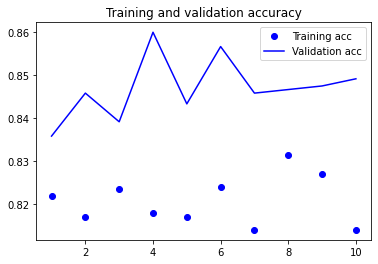

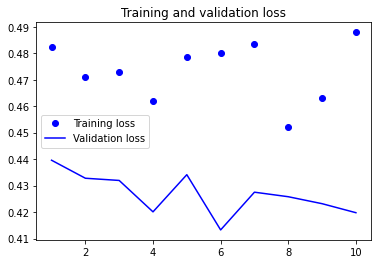

In [32]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [33]:
model2.save('modelo_ft.h5')

In [34]:
model_VGG19.save('modelo_vgg19au.h5')

In [37]:
model2.save('model3.h5')